# Computer Vision Sheet 1

Dependencies

In [10]:
import cv2 as cv
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
import random
import time
import sys
import math

random.seed(time.time)

Execute the following code snippet before proceeding. It contains the helper functions used in the code.

In [11]:
def displayImg(winName, img):
    """ Helper Function to display images
    arguments:
    winName -- windows name
    img -- input image
    """
    cv.imshow(winName, img)
    cv.waitKey(0)


def computeIntegral(srcImg):
    """ Helper function to compute an integral image
    arguments:
    srcImg -- input Image
    """
    intImg = np.zeros(srcImg.shape, dtype=float)
    for y in range(srcImg.shape[0]):
        for x in range(srcImg.shape[1]):
            if x == 0 and y == 0:
                intImg[y, x] = srcImg[y, x]
            elif x == 0 and y > 0:
                intImg[y, x] = srcImg[y, x] + intImg[y-1, x]
            elif y == 0 and x > 0:
                intImg[y, x] = srcImg[y, x] + intImg[y, x-1]
            else:
                intImg[y, x] = srcImg[y, x] + intImg[y, x-1] + \
                    intImg[y-1, x] - intImg[y-1, x-1]
    return intImg

# The following function is inspired from the OpenCV Tutorials of histogram equalization
def customEqualizeHist(srcImg):
    """ Helper function to equalize histogram of an image
    arguments:
    srcImg -- input Image
    """
    hist, _ = np.histogram(srcImg.ravel(), 256, [0, 256])
    cumHist = hist.cumsum()

    maxVal = cumHist[cumHist > 0].max()
    minVal = cumHist[cumHist > 0].min()

    transformedHist = ((cumHist[cumHist > 0] - minVal)
                       * 255/(maxVal - minVal)).astype('uint8')

    plt.plot(hist, color='r')
    plt.plot(transformedHist, color='b')
    plt.show()

    return transformedHist[srcImg]


def computeGaussianKernel(ksize, sigmaX, sigmaY):
    """ Helper function to compute a Gaussian Kernel
    arguments:
    ksize -- Kernel Size
    sigmaX -- standard deviation along X axis
    sigmaY -- standard deviation along Y axis
    """
    kernel = np.zeros((ksize, ksize), dtype=np.float64)

    for i in range(ksize):
        x = abs(i - math.floor(ksize / 2))
        for j in range(ksize):
            y = abs(j - math.floor(ksize / 2))
            factor = -(x * x + y * y) / (2 * sigmaX * sigmaY)
            kernel[i, j] = (1./(2 * math.pi * sigmaX * sigmaY)
                            ) * math.exp(factor)

    return kernel


def separateFilter(srcKernel, srcImg):
    """ Helper function to separate filters based on separability condition
    arguments:
    srcKernel -- input Kernel
    srcImg -- input Image
    """
    U, W, Vt = np.linalg.svd(srcKernel)
    rank = np.linalg.matrix_rank(srcKernel)
    if rank == 1:
        sepKernelX = math.sqrt(W[0]) * U[:, 0]
        sepKernelY = math.sqrt(W[0]) * Vt[:, 0]
        filteredSepImg = cv.sepFilter2D(grayImg, -1, sepKernelX, sepKernelY)
    else:
        sepKernel = W[0] * U[:, 0] * Vt[:, 0]
        filteredSepImg = cv.sepFilter2D(grayImg, -1, sepKernel, sepKernel)
    return filteredSepImg

Run the following code snippet before proceeding.

In [12]:
origImg = cv.imread('../images/bonn.png')
displayImg('Original Image', origImg)

cols = origImg.shape[1]
rows = origImg.shape[0]

grayImg = cv.cvtColor(origImg, cv.COLOR_BGR2GRAY).astype('float64')
grayImg /= 255.0
displayImg('Gray Image', grayImg)

cv.destroyAllWindows()

Task 1: Rectangles and Integral Images

In [13]:
print('Task 1:')

# 1a
intImg = computeIntegral(grayImg)
displayImg('Integral Image', intImg)

print('-------------------------------------------------------------------------')

# 1b - i
meanPixelVal = (np.sum(grayImg) * 255.0)/(cols * rows)
print('1b - i: Mean value without using function integral: ' + str(meanPixelVal))

# 1b - ii
intImg2 = cv.integral(grayImg)
meanPixelVal2 = (intImg2[rows-1, cols-1] * 255.0) / (cols * rows)
print('1b - ii: Mean value using OpenCV function integral: ' + str(meanPixelVal2))

# 1b - iii
meanPixelVal3 = (intImg[rows-1, cols-1] * 255.0) / (cols * rows)
print('1b - iii: Mean value using custom function integral: ' + str(meanPixelVal3))
print('-------------------------------------------------------------------------')

# 1c
meanGrayVals = np.zeros((10,3), dtype = float)
start_time = time.time()
for i in range(10):
    ry = random.randint(99,rows-101)
    rx = random.randint(99,cols-101)
    randSquarePatch = grayImg[ry:ry+101, rx:rx+101]

    meanGrayVals[i, 0] = (np.sum(randSquarePatch) * 255.0) / randSquarePatch.size

    intSquarePatch = cv.integral(randSquarePatch)
    meanGrayVals[i, 1] = (intSquarePatch[randSquarePatch.shape[0]-1, randSquarePatch.shape[1]-1] * 255.0) / randSquarePatch.size

    intSquarePatch = computeIntegral(randSquarePatch)
    meanGrayVals[i, 2] = (intSquarePatch[randSquarePatch.shape[0]-1, randSquarePatch.shape[1]-1] * 255.0) / randSquarePatch.size

end_time = time.time()
print('1c) Time taken: ' + str(round(end_time - start_time, 3)) + ' seconds')
print('-------------------------------------------------------------------------')
print("Without Integral | OpenCV Integral | Custom Integral")
print(np.array2string(meanGrayVals, separator=' | '))

cv.destroyAllWindows()

Task 1:
-------------------------------------------------------------------------
1b - i: Mean value without using function integral: 125.25414583333331
1b - ii: Mean value using OpenCV function integral: 124.75484722222235
1b - iii: Mean value using custom function integral: 125.25414583332685
-------------------------------------------------------------------------
1c) Time taken: 0.11 seconds
-------------------------------------------------------------------------
Without Integral | OpenCV Integral | Custom Integral
[[ 47.36084698 |  46.61101853 |  47.36084698] |
 [143.11538085 | 140.6152338  | 143.11538085] |
 [116.18400157 | 114.29134399 | 116.18400157] |
 [138.5721988  | 137.03705519 | 138.5721988 ] |
 [155.8930497  | 152.74179002 | 155.8930497 ] |
 [130.05087736 | 128.84677973 | 130.05087736] |
 [127.91098912 | 125.3138908  | 127.91098912] |
 [ 58.53984903 |  58.06813058 |  58.53984903] |
 [ 58.91206744 |  57.880796   |  58.91206744] |
 [125.43956475 | 123.03999608 | 125.439564

Task 2: Histogram Equalization

Task 2:


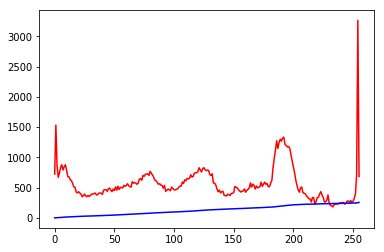

In [14]:
print('Task 2:')
# 2a
equalizedImg = cv.equalizeHist((grayImg*255.0).astype('uint8'))
displayImg('Default Equalization', equalizedImg)

# 2b
displayImg('Custom Equalization', customEqualizeHist((grayImg*255.0).astype('uint8')))

cv.destroyAllWindows()

Task 3: Proof that convolutions are in the continuous case associative.

Let f and g be two functions, the convolution of which is,
$$(f * g)(t)=\int_{0}^{t} f(s) g(t-s) ds$$

Now, expanding this to three functions,

$
((f * g)*h)(t) = \int_{0}^{t} (f*g)(s) h(t-s) ds = \int_{s=0}^{t}(\int_{u=0}^{t} f(s) g(s-u) du) h(t-s) ds\\
= \int_{s=0}^{t} \int_{u=0}^{t} f(s) g(s-u)  h(t-s) du ds\\
= \int_{u=0}^{t} \int_{s=0}^{t-u} f(u) g(s) h(t-s-u) ds du\\
= \int_{u=0}^{t} f(u) (\int_{s=0}^{t-u}  g(s) h(t-u-s) ds) du\\
= \int_{u=0}^{t} f(u) (g*h) (t-u) du = (f*(g * h))(t)
$

Therefore, convolutions are associative.

Task 4: 2D Filtering

In [15]:
print('Task 4:')

sigma = 2 * math.sqrt(2)

# 4a
blurredImg = cv.GaussianBlur(grayImg, (3, 3), sigma)
displayImg('Using Gaussian Blur', blurredImg)

# 4b
customGaussianKernel = computeGaussianKernel(5, sigma, sigma)
customFilteredImg = cv.filter2D(grayImg, -1, customGaussianKernel)
displayImg('Using Filter2d', customFilteredImg)

# 4c
gaussianKernel = cv.getGaussianKernel(3, sigma)
filteredImg = cv.sepFilter2D(grayImg, -1, gaussianKernel, gaussianKernel)
displayImg('Using SepFilter2d', filteredImg)

diffGaussCustom = np.absolute(blurredImg - customFilteredImg)
diffGaussSep = np.absolute(blurredImg - filteredImg)
diffCustSep = np.absolute(customFilteredImg - filteredImg)

print('-------------------------------------------------------------------------')
print("4a: Max Pixel Difference between Gaussian Blur and Filter2D = " + str(diffGaussCustom.max()*255))
print('-------------------------------------------------------------------------')
print("4b: Max Pixel Difference between Gaussian Blur and SepFilter2D = " + str(diffGaussSep.max()*255))
print('-------------------------------------------------------------------------')
print("4c: Max Pixel Difference between Filter2D and SepFilter2D = " + str(diffCustSep.max()*255))
print('-------------------------------------------------------------------------')

cv.destroyAllWindows()

Task 4:
-------------------------------------------------------------------------
4a: Max Pixel Difference between Gaussian Blur and Filter2D = 171.29073770201367
-------------------------------------------------------------------------
4b: Max Pixel Difference between Gaussian Blur and SepFilter2D = 0.0
-------------------------------------------------------------------------
4c: Max Pixel Difference between Filter2D and SepFilter2D = 171.29073770201367
-------------------------------------------------------------------------


Task 5: Multiple Gaussian Filters

In [16]:
print('Task 5:')

# 5a
gaussianKernel = gaussianKernel = cv.getGaussianKernel(3, 2 * math.sqrt(2))
gaussianKernel2 = cv.getGaussianKernel(3, 2)

filteredImg1 = cv.filter2D(grayImg, -1, gaussianKernel2, gaussianKernel2)
filteredImg1 = cv.filter2D(grayImg, -1, gaussianKernel2, gaussianKernel2)
displayImg('Sigma=2', filteredImg1)

# 5b
filteredImg2 = cv.filter2D(grayImg, -1, gaussianKernel, gaussianKernel)
displayImg('Sigma=2*sqrt(2)', filteredImg2)

diffFilt1Filt2 = np.absolute(filteredImg1 - filteredImg2)
print('-------------------------------------------------------------------------')
print("Max Pixel Difference between Filtered Image1 and Image2 = " + str(diffFilt1Filt2.max()*255))

cv.destroyAllWindows()

Task 5:
-------------------------------------------------------------------------
Max Pixel Difference between Filtered Image1 and Image2 = 2.3596084093372856


Task 6: Proof that convolution two times with a Gaussian kernel with standard deviation $\sigma$ is the same as convolution once with a Gaussian kernel with standard deviation $\sqrt{2}\sigma$

By definition, a gaussian functuon,

$G_{\sigma}(x) = \frac{1}{\sqrt{2\pi\sigma^2}}*e^{\frac{-x^2}{2*\sigma^2}}$

Now, 
$
(G{_\sigma}*G_{\sigma})(x) = \int_{-\infty}^{\infty} G(x) G(x-u) du \\
= \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi\sigma^2}}*e^{-\frac{x^2}{2*\sigma^2}}* 
\frac{1}{\sqrt{2\pi\sigma^2}}*e^{\frac{-(x-u)^2}{2*\sigma^2}}du\\
= \frac{1}{2\pi\sigma^2} \int_{-\infty}^{\infty} e^{-\frac{u^2+(x-u)^2}{2*\sigma^2}}du\\
= \frac{1}{2\pi\sigma^2} \int_{-\infty}^{\infty} e^{-\frac{2u^2+x^2-2ux}{2*\sigma^2}}du\\
= \frac{1}{2\pi\sigma^2} * e^{-\frac{x^2}{2*\sigma^2}} \int_{-\infty}^{\infty} e^{-\frac{u^2+ux}{\sigma^2}}du\\
= \frac{1}{2\pi\sigma^2} * e^{-\frac{x^2}{2*\sigma^2}} \int_{-\infty}^{\infty} e^{(-\frac{u^2}{\sigma^2}+\frac{ux}{\sigma^2}+0)}du
$ -- (1)

Now, we know, $\int_{-\infty}^{\infty} e^{-Au^2+Bu+C} = \sqrt{\frac{\pi}{A}}*e^{(\frac{B^2}{4*A}+C)}$ --(2)

Therefore, combining (1) and (2) we get,

$
(G_\sigma*G_\sigma)(x) = \frac{1}{2\pi\sigma^2} * e^{-\frac{x^2}{2*\sigma^2}} \sqrt{\pi*\sigma^2} * e^{-\frac{x^2*\sigma^2}{2*\sigma^4}}\\
= \frac{1}{\sqrt{2\pi(\sqrt{2}\sigma)^2}} * e^{(-\frac{x^2}{2*\sigma^2})} * e^{-\frac{x^2*}{(\sqrt{2}*\sigma)^2}}
= G_{\sqrt{2}\sigma}(x)
$

Task 7: Denoising

In [17]:
print('Task 7:')

noisyImg = grayImg.copy()
for y in range(rows):
    for x in range(cols):
        if np.random.sample() <= 0.3:
            noisyImg[y, x] = np.random.choice([0, 1/255])
cv.imshow('Salt and Pepper Noise', noisyImg)
cv.waitKey(0)
# print(np.absolute(noisyImg - grayImg).max())

# 7a
# gaussianKernel = cv.getGaussianKernel(3, 1)
# smoothedGaussianImg = cv.sepFilter2D(noisyImg, -1, gaussianKernel, gaussianKernel)
smoothedGaussianImg = cv.GaussianBlur(noisyImg, (5,5), 1)
displayImg('Smoothed by Gaussian Kernel', smoothedGaussianImg)

# 7b
smoothedMedianImg = cv.medianBlur((noisyImg*255).astype('uint8'), 5)
displayImg('Smoothed by Median Blur', smoothedMedianImg)

# 7c
smoothedBilateralImg = cv.bilateralFilter((noisyImg*255).astype('uint8'), 5, 127, 127)
displayImg('Smoothed by Bilateral Blur', smoothedBilateralImg)

diffOrigGauss = np.mean(grayImg*255) - np.mean(smoothedGaussianImg*255)
diffOrigMedian = np.mean(grayImg*255) - np.mean(smoothedMedianImg)
diffOrigBilat = np.mean(grayImg*255) - np.mean(smoothedBilateralImg)

# Minimum difference results obtained for kernel size 5 x 5
print('-------------------------------------------------------------------------')
print("7a: Difference between mean of Original and Gaussian Blur = " + str(diffOrigGauss))
print('-------------------------------------------------------------------------')
print("7b: Difference between mean of Original and Median Blur = " + str(diffOrigMedian))
print('-------------------------------------------------------------------------')
print("7c: Difference between mean of Original and Bilateral Filter = " + str(diffOrigBilat))
print('-------------------------------------------------------------------------')

cv.destroyAllWindows()

Task 7:
-------------------------------------------------------------------------
7a: Difference between mean of Original and Gaussian Blur = 37.16636505943768
-------------------------------------------------------------------------
7b: Difference between mean of Original and Median Blur = 14.368437500000013
-------------------------------------------------------------------------
7c: Difference between mean of Original and Bilateral Filter = 34.835979166666675
-------------------------------------------------------------------------


Task 8: Separability of Filters

In [18]:
print('Task 8:')

kernel1 = np.array(([0.0113, 0.0838, 0.0113],
                    [0.0838, 0.6193, 0.0838],
                    [0.0113, 0.0838, 0.0113]))

kernel2 = np.array(([-0.8984, 0.1472, 1.1410],
                    [-1.9075, 0.1566, 2.1359],
                    [-0.8659, 0.0573, 1.0337]))

filteredK1Img = cv.filter2D(grayImg, -1, kernel1)
displayImg('Filtered by Custom Kernel 1', filteredK1Img)

filteredK2Img = cv.filter2D(grayImg, -1, kernel2)
displayImg('Filtered by Custom Kernel 2', filteredK2Img)

filteredSepK1Img = separateFilter(kernel1, grayImg)
displayImg('Filtered by Separated Custom Kernel 1', filteredSepK1Img)

filteredSepK2Img = separateFilter(kernel2, grayImg)
displayImg('Filtered by Separated Custom Kernel 2', filteredSepK1Img)

cv.destroyAllWindows()

Task 8:
